### Finetuning

Hidden states are trained along with a classification head using a small labeled dataset. This allows hidden states to adapt to the dataset and achieve better performance on the dataset of interest. 

Finetuning a DistilBert model with emotions dataset

In [20]:
import numpy as np
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import Trainer, TrainingArguments
import torch
from datasets import load_dataset

from sklearn.metrics import accuracy_score, f1_score


In [21]:

num_labels=6
model_ckpt = 'distilbert-base-uncased'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Classification weights are not initialised, so the model needs to be trained for classification

Load emotions dataset

In [22]:
emotions = load_dataset('SetFit/emotion')

Using custom data configuration SetFit--emotion-e444b7640ce3116e
Found cached dataset json (/home/vivek/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

In [24]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=False)
    
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at /home/vivek/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-2a5326c6c3f4841d.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /home/vivek/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-4eed9c48a8c5fdbc.arrow


In [25]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

Performance Metric

In [26]:
def compute_metrics(pred):
    
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

In [53]:
batch_size = 64
logging_steps = len(emotions_encoded['train'])//batch_size

model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
                                    output_dir=model_name,
                                    num_train_epochs=3,
                                    learning_rate=2e-5,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    evaluation_strategy='epoch',
                                    disable_tqdm=False,
                                    logging_steps=logging_steps,
                                    log_level='error'
                                    
                                )

In [54]:
(emotions_encoded['train'].select(range(100)))

Dataset({
    features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
    num_rows: 100
})

In [55]:
trainer = Trainer(model=model,
                 args=training_args,
                 compute_metrics=compute_metrics,
                 train_dataset=emotions_encoded['train'],
                 eval_dataset=emotions_encoded['validation'],
                 tokenizer=tokenizer)

trainer.train()

/home/vivek/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 0.4679, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.21185101568698883, 'eval_accuracy': 0.916, 'eval_f1': 0.9149502379056821, 'eval_runtime': 28.9137, 'eval_samples_per_second': 69.171, 'eval_steps_per_second': 1.107, 'epoch': 1.0}
{'loss': 0.1797, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.16031555831432343, 'eval_accuracy': 0.9295, 'eval_f1': 0.9299302149531521, 'eval_runtime': 24.5111, 'eval_samples_per_second': 81.596, 'eval_steps_per_second': 1.306, 'epoch': 2.0}
{'loss': 0.1295, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.1530715972185135, 'eval_accuracy': 0.9365, 'eval_f1': 0.9365077858594721, 'eval_runtime': 23.8879, 'eval_samples_per_second': 83.724, 'eval_steps_per_second': 1.34, 'epoch': 3.0}
{'train_runtime': 2559.1136, 'train_samples_per_second': 18.756, 'train_steps_per_second': 0.293, 'train_loss': 0.2590314331054687, 'epoch': 3.0}


TrainOutput(global_step=750, training_loss=0.2590314331054687, metrics={'train_runtime': 2559.1136, 'train_samples_per_second': 18.756, 'train_steps_per_second': 0.293, 'train_loss': 0.2590314331054687, 'epoch': 3.0})

Evaluation of the trained model: Confusion Matrix

Get predictions on validation set

In [56]:
preds_output = trainer.predict(emotions_encoded['validation'])
preds_output

  0%|          | 0/32 [00:00<?, ?it/s]

PredictionOutput(predictions=array([[ 5.525443  , -0.9815118 , -0.973543  , -1.5145116 , -1.3344861 ,
        -2.2613842 ],
       [ 5.594614  , -1.0743959 , -1.7996869 , -0.8963505 , -1.0997484 ,
        -2.2259629 ],
       [-1.5744784 ,  3.087226  ,  3.2444787 , -1.7862616 , -1.978795  ,
        -2.2117457 ],
       ...,
       [-1.2767332 ,  5.7414975 , -0.11244208, -1.4827987 , -2.0261493 ,
        -1.7362435 ],
       [-1.94293   ,  3.280787  ,  3.3942745 , -2.0298085 , -1.9175754 ,
        -1.9869835 ],
       [-1.7215466 ,  5.493597  , -0.49774283, -1.961376  , -2.0292428 ,
        -0.56280565]], dtype=float32), label_ids=array([0, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.1530715972185135, 'test_accuracy': 0.9365, 'test_f1': 0.9365077858594721, 'test_runtime': 24.2235, 'test_samples_per_second': 82.564, 'test_steps_per_second': 1.321})

In [57]:
preds_output.metrics

{'test_loss': 0.1530715972185135,
 'test_accuracy': 0.9365,
 'test_f1': 0.9365077858594721,
 'test_runtime': 24.2235,
 'test_samples_per_second': 82.564,
 'test_steps_per_second': 1.321}

In [58]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = preds_output.label_ids

In [59]:
y_preds

array([0, 0, 2, ..., 1, 2, 1])

In [60]:
label_map = list(set(zip(emotions['train']['label'], emotions['train']['label_text'])))
label_map.sort(key= lambda pair: pair[0])
labels = [l[1] for l in label_map]
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

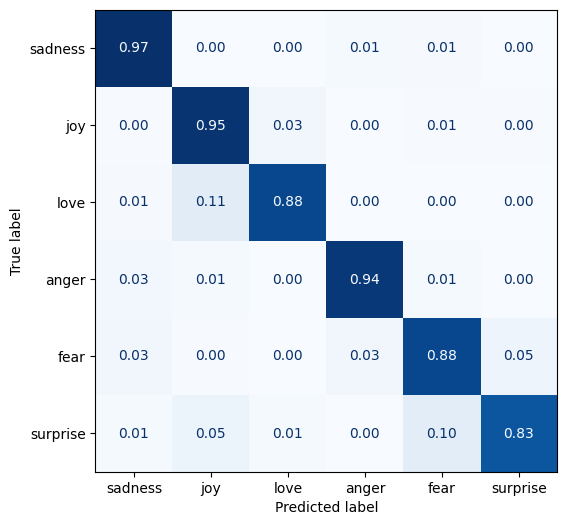

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_mat(y_true, y_pred, labels):

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.show()


plot_confusion_mat(y_valid, y_preds, labels)